In [11]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [12]:
pip install torchvision

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# ===== Imports =====
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))   # maps [0,1] → [-1,1]
])

mnist = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(mnist, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

class ForwardOU:
    """
    dX = -lambda * X dt + sqrt(2*lambda) dW
    Marginal: X_t | X_0 ~ N( X0*exp(-lambda t), (1-exp(-2 lambda t)) I )
    """
    def __init__(self, lambda_=1.0):
        self.lmbd = float(lambda_)

    def mean(self, x0, t):
        # t: [B]
        a = torch.exp(-self.lmbd * t)[:, None, None, None]
        return a * x0

    def std(self, t):
        # std(t) = sqrt(1 - exp(-2 lambda t))
        v = 1.0 - torch.exp(-2.0 * self.lmbd * t)   # [B]
        v = torch.clamp(v, min=1e-12)
        return torch.sqrt(v)[:, None, None, None]

    def diffusion_coeff(self, t):
        # g(t) = sqrt(2 lambda)  (constant in time here)
        return torch.sqrt(torch.tensor(2.0 * self.lmbd, device=t.device, dtype=t.dtype)) * torch.ones_like(t)

def sample_noisy(x0, t, sde: ForwardOU):
    mean = sde.mean(x0, t)
    std = sde.std(t)
    z = torch.randn_like(x0)  
    return mean + std * z

def conditional_score(x0, xt, t, sde: ForwardOU):
    mean = sde.mean(x0, t)
    std = sde.std(t)
    var = std * std
    return -(xt - mean) / (var + 1e-5)

def show_batch(x, title=""):
    x = x.detach().cpu()
    grid = torch.cat([x[i] for i in range(x.size(0))], dim=2)
    plt.figure(figsize=(10, 2))
    plt.imshow(grid.squeeze(), cmap="gray")
    plt.title(title)
    plt.axis("off")
    plt.show()


In [14]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim=64):
        super().__init__()
        assert dim % 2 == 0
        self.dim = dim
        self.lin1 = nn.Linear(dim, dim)
        self.act = nn.SiLU()
        self.lin2 = nn.Linear(dim, dim)

    def forward(self, t):
        # t: [B], assumed in [0,1]
        half = self.dim // 2
        # frequencies on device/dtype
        freqs = torch.exp(
            torch.arange(half, device=t.device, dtype=t.dtype) * (-math.log(10000.0) / (half - 1))
        )  # [half]
        args = t[:, None] * freqs[None, :]  # [B, half]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)  # [B, dim]
        emb = self.lin1(emb)
        emb = self.act(emb)
        emb = self.lin2(emb)
        return emb

class ScoreNet(nn.Module):
    def __init__(self, time_dim=64):
        super().__init__()
        self.time_mlp = TimeEmbedding(dim=time_dim)
        self.net = nn.Sequential(
            nn.Conv2d(1 + time_dim, 64, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.SiLU(),
            nn.Conv2d(64, 1, 3, padding=1),
        )

    def forward(self, x, t):
        # t: [B]
        emb = self.time_mlp(t)                  # [B, time_dim]
        emb = emb[:, :, None, None]             # [B, time_dim, 1, 1]
        emb = emb.expand(-1, -1, x.size(2), x.size(3))
        inp = torch.cat([x, emb], dim=1)
        return self.net(inp)



Epoch 1/20 | avg loss = 3.747350
Epoch 2/20 | avg loss = 3.382578
Epoch 3/20 | avg loss = 3.294023
Epoch 4/20 | avg loss = 3.354028
Epoch 5/20 | avg loss = 3.327219
Epoch 6/20 | avg loss = 3.231182
Epoch 7/20 | avg loss = 3.101475
Epoch 8/20 | avg loss = 3.046013
Epoch 9/20 | avg loss = 2.641143
Epoch 10/20 | avg loss = 2.438723
Epoch 11/20 | avg loss = 2.260036
Epoch 12/20 | avg loss = 1.811809
Epoch 13/20 | avg loss = 2.017937
Epoch 14/20 | avg loss = 2.260308
Epoch 15/20 | avg loss = 2.100981
Epoch 16/20 | avg loss = 2.255251
Epoch 17/20 | avg loss = 1.851101
Epoch 18/20 | avg loss = 1.653203
Epoch 19/20 | avg loss = 1.841058
Epoch 20/20 | avg loss = 1.428815


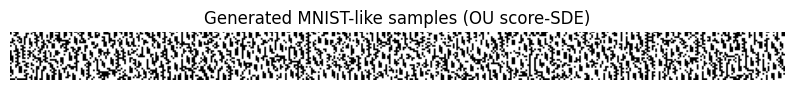

In [ ]:
# ===== Training (with periodic checkpoint saving) =====
sde = ForwardOU(lambda_=1.0)
model = ScoreNet(time_dim=64).to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-4)

num_epochs = 20

ckpt_dir = "./checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)
save_every_epochs = 5

global_step = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    n_batches = 0

    for x0, _ in loader:
        x0 = x0.to(device, non_blocking=True)

        # avoid t=0 exactly (std=0); keep t in [eps, 1]
        eps = 1e-4
        t = eps + (1.0 - eps) * torch.rand(x0.size(0), device=device)

        xt = sample_noisy(x0, t, sde)
        target = conditional_score(x0, xt, t, sde)

        pred = model(xt, t)
        loss = F.mse_loss(pred, target)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        global_step += 1
        running_loss += loss.item()
        n_batches += 1

    avg_loss = running_loss / max(1, n_batches)
    print(f"Epoch {epoch+1}/{num_epochs} | avg loss = {avg_loss:.6f}")

    # periodic checkpoint
    if (epoch + 1) % save_every_epochs == 0 or (epoch + 1) == num_epochs:
        ckpt_path = os.path.join(ckpt_dir, f"ckpt_epoch_{epoch+1}.pt")
        torch.save(
            {
                "epoch": epoch + 1,
                "global_step": global_step,
                "lambda": sde.lmbd,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "avg_loss": avg_loss,
            },
            ckpt_path,
        )

In [ ]:
import math
import torch

@torch.no_grad()
def sample_reverse_euler_maruyama(
    model,
    sde,
    num_steps=1000,
    batch_size=16,
    device="cuda",
    t_min=1e-3,
    corrector_steps=1,      # try 0, 1, 2...
    snr=0.1                 # try 0.05~0.2
):
    """
    Predictor-Corrector sampler for OU reverse SDE.
    Forward: dX = -λ X dt + sqrt(2λ) dW
    Reverse (backward in time): x <- x + (λ x + g^2 score) dt + g sqrt(dt) z
    plus optional Langevin corrector steps.
    """
    model.eval()

    T = 1.0
    # We will integrate from T down to t_min (not 0)
    dt = (T - t_min) / num_steps

    x = torch.randn(batch_size, 1, 28, 28, device=device)

    g = math.sqrt(2.0 * sde.lmbd)   # scalar
    g2 = g * g

    for k in range(num_steps):
        t = T - k * dt
        t_batch = torch.full((batch_size,), t, device=device)

        # ---- Corrector: Langevin MCMC targeting p_t(x) using the score ----
        # This can significantly improve sample quality for simple nets.
        for _ in range(corrector_steps):
            score = model(x, t_batch)
            noise = torch.randn_like(x)

            # adaptive step size based on score/noise norms (common heuristic)
            score_norm = torch.norm(score.reshape(batch_size, -1), dim=1).mean()
            noise_norm = torch.norm(noise.reshape(batch_size, -1), dim=1).mean()
            step_size = (snr * noise_norm / (score_norm + 1e-12)) ** 2

            x = x + step_size * score + torch.sqrt(2.0 * step_size) * noise

        # ---- Predictor: reverse SDE Euler–Maruyama step (FIXED SIGN) ----
        score = model(x, t_batch)
        noise = torch.randn_like(x)

        drift_backward = (sde.lmbd * x + g2 * score)  # <-- key fix
        x = x + drift_backward * dt + g * math.sqrt(dt) * noise

    return x


In [ ]:
sde = ForwardOU(lambda_=checkpoint["lambda"])

model = ScoreNet(time_dim=64).to(device)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=2e-4,
    weight_decay=1e-4,
)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

# Training counters
start_epoch = checkpoint["epoch"]      # last completed epoch
global_step = checkpoint["global_step"]

print(f"Resuming from epoch {start_epoch}, global step {global_step}")


Resuming from epoch 20, global step 18760


In [20]:
num_epochs = 50   # total desired epochs (not additional!)

for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    n_batches = 0

    for x0, _ in loader:
        x0 = x0.to(device)

        eps = 1e-4
        t = eps + (1.0 - eps) * torch.rand(x0.size(0), device=device)

        xt = sample_noisy(x0, t, sde)
        target = conditional_score(x0, xt, t, sde)

        pred = model(xt, t)
        loss = F.mse_loss(pred, target)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        global_step += 1
        running_loss += loss.item()
        n_batches += 1

    avg_loss = running_loss / max(1, n_batches)
    print(f"Epoch {epoch+1}/{num_epochs} | avg loss = {avg_loss:.6f}")

    # save again if you want
    if (epoch + 1) % 5 == 0 or (epoch + 1) == num_epochs:
        torch.save(
            {
                "epoch": epoch + 1,
                "global_step": global_step,
                "lambda": sde.lmbd,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "avg_loss": avg_loss,
            },
            f"./checkpoints/ckpt_epoch_{epoch+1}.pt",
        )


Epoch 21/50 | avg loss = 2.053966
Epoch 22/50 | avg loss = 1.581997
Epoch 23/50 | avg loss = 1.489731
Epoch 24/50 | avg loss = 1.501504
Epoch 25/50 | avg loss = 1.495577
Epoch 26/50 | avg loss = 1.457652
Epoch 27/50 | avg loss = 1.600202
Epoch 28/50 | avg loss = 1.561642
Epoch 29/50 | avg loss = 1.370798
Epoch 30/50 | avg loss = 1.506519
Epoch 31/50 | avg loss = 1.760324
Epoch 32/50 | avg loss = 1.701870
Epoch 33/50 | avg loss = 1.732056
Epoch 34/50 | avg loss = 1.088316
Epoch 35/50 | avg loss = 1.556457
Epoch 36/50 | avg loss = 1.618743
Epoch 37/50 | avg loss = 1.552407
Epoch 38/50 | avg loss = 1.077587
Epoch 39/50 | avg loss = 1.082846
Epoch 40/50 | avg loss = 1.431240
Epoch 41/50 | avg loss = 1.460644
Epoch 42/50 | avg loss = 1.482765
Epoch 43/50 | avg loss = 1.299756
Epoch 44/50 | avg loss = 1.194931
Epoch 45/50 | avg loss = 1.153536
Epoch 46/50 | avg loss = 1.503652
Epoch 47/50 | avg loss = 1.173379
Epoch 48/50 | avg loss = 1.364926
Epoch 49/50 | avg loss = 1.371504
Epoch 50/50 | 

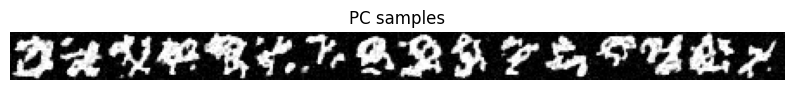

In [ ]:
samples = sample_reverse_pc(
    model, sde,
    num_steps=1000,
    batch_size=16,
    device=device,
    t_min=1e-3,
    corrector_steps=1,
    snr=0.1
)

samples = (samples.clamp(-1, 1) + 1) / 2.0
show_batch(samples, "Generated MNIST-like samples")
